In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump
from sklearn.svm import LinearSVC

In [2]:
path = './engineered_dataset.csv'
df = pd.read_csv(path)
df.describe(include='all')

,year,DayOfWeek,x_cartesian,y_cartesian,z_cartesian,sin_time,cos_time,is_violent
count,2.215024e+06,2215024,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06,2215024
unique,NaN,7,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Friday,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,337941,NaN,NaN,NaN,NaN,NaN,1112863
mean,2.010265e+03,NaN,-4.238136e-01,-6.672310e-01,6.124822e-01,-2.442137e-01,-6.009038e-02,NaN
std,4.486245e+00,NaN,3.423043e-03,5.367794e-03,3.131448e-03,6.403588e-01,7.257340e-01,NaN
min,2.003000e+03,NaN,-4.250327e-01,-6.681009e-01,6.116358e-01,-1.000000e+00,-1.000000e+00,NaN
25%,2.006000e+03,NaN,-4.239793e-01,-6.673972e-01,6.122589e-01,-8.660254e-01,-7.853169e-01,NaN
50%,2.010000e+03,NaN,-4.237344e-01,-6.672350e-01,6.125680e-01,-3.826834e-01,-1.478094e-01,NaN
75%,2.014000e+03,NaN,-4.235967e-01,-6.671199e-01,6.126930e-01,2.588190e-01,7.071068e-01,NaN


# Utility Functions
Below are a few utility functions that will be used for training each model.

In [3]:
def print_metrics(classifier, X_test, y_test):
  '''Prints the various metrics(accuracy, precision, recall, F-Score) of a classifier
  '''
  accuracy = classifier.score(X_test, y_test)
  y_pred = classifier.predict(X_test)

  precision = precision_score(
      y_true=y_test,
      y_pred=y_pred
  )

  recall = recall_score(
      y_true=y_test,
      y_pred=y_pred
  )

  f1 = f1_score(
      y_true=y_test,
      y_pred=y_pred
  )

  print('Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F score: {f1}'.format(
      accuracy=accuracy,
      precision=precision,
      recall=recall,
      f1=f1
  ))
    
def evaluate_parameter(parameter, values, classifier, X_train, y_train, scoring):
  '''Helper that evaluates a single parameter over a set of parameters. Grid search is performed
  and it returns the the mean test score of each value
  '''
  grid_search = GridSearchCV(
      estimator=classifier,
      param_grid={parameter: values},
      verbose=10,
      n_jobs=-1,
      cv=3,
      scoring=scoring
  )
  grid_search.fit(X_train, y_train)
  param_values = [param[parameter] for param in grid_search.cv_results_['params']]
  result = dict(zip(param_values, grid_search.cv_results_['mean_test_score']))
  return {
      'scores': result,
      'grid_search': grid_search
  }

def evaluate_parameters(parameters, classifier, X_train, y_train, scoring=None):
  '''Evaluates single parameters (i.e. independent to other parameters) over their given
  ranges. Then plots the scores vs the parameter values.
  '''
  param_value_scores = {}
  
  for key, val in parameters.items():
    print(key)
    param_value_scores[key] = evaluate_parameter(key, val, classifier, X_train, y_train, scoring)

  index = 1
  plt.figure(figsize=(20, 15))
  for key, val in param_value_scores.items():
    plt.subplot(3, 2, index)
    plt.title(key)
    param_values = list(val['scores'].keys())
    scores = list(val['scores'].values())
    plt.plot(param_values, scores)
    index += 1
  plt.show()

  return param_value_scores


# Training
To ensure relevance to today, we will be taking the more recent data. In our case we will take everything from 2015 and on.

Due to the nature of the problem, we would prefer to have a higher Recall over Precision. False positives would not seriously affect someone. This is because it is safer to avoid a place due to a possible danger, rather than go there.

In [4]:
final_df = df
final_df = final_df[final_df['year'] >= 2015]

### Random Forest
For the random forest classifier, we will use all the available features to train. `DayOfWeek` will be one hot encoded since it is a categorical variable

In [5]:
X = final_df[[
  'DayOfWeek',
  'year',
  'x_cartesian',
  'y_cartesian',
  'z_cartesian',
  'sin_time',
  'cos_time',
]]


X = X.values
X = X.tolist()

column_transformer = ColumnTransformer(
  [("OHE", OneHotEncoder(handle_unknown='ignore'), [0])],
  remainder='passthrough'
)
X = column_transformer.fit_transform(X)

y = final_df[['is_violent']].values
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  random_state=2
)

First, we'll train a baseline random forest to compare with our tuned random forest. Below will also print out the metrics that we care about.

In [6]:
baseline_rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
baseline_rf.fit(X_train, y_train.ravel())

print_metrics(
    classifier=baseline_rf,
    X_test=X_test,
    y_test=y_test
)

Accuracy: 0.6434562505404322, Precision: 0.6805398656281586, Recall: 0.6573533001191689, F score: 0.6687456636844987


Next, we can evaluate a range of parameters to see which we should be performing a grid search over. The reasoning for this is because it is computationally expensive to check large values of each parameter. Instead, we can evaluate each in isolation, then tune the ranges. Note that the ranges have already been tuned to a 'sweet spot'

max_depth
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.5s
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   32.9s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   35.0s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   39.2s finished


min_samples_split
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    9.4s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   11.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   12.5s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   15.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   16.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.6s finished


min_samples_leaf
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


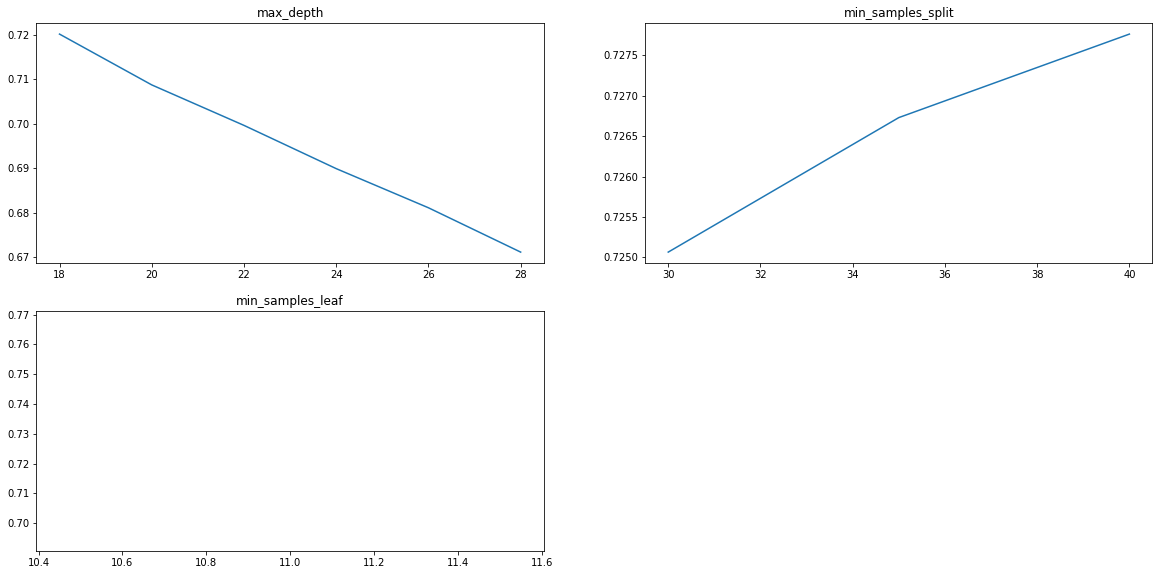

In [7]:
parameters = {
    'max_depth': np.arange(18, 30, 2),
    'min_samples_split': np.arange(30, 45, 5),
    'min_samples_leaf': np.arange(11, 13, 2),
}

ranking = evaluate_parameters(
  parameters, 
  classifier=RandomForestClassifier(n_estimators=10, n_jobs=-1),
  X_train=X_train,
  y_train=y_train.ravel(),
  scoring='recall'
)

After tuning the parameters dict above, we can finally perform a grid search on our random forest classifier.

In [8]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=0, random_state=1),
    param_grid=parameters,
    verbose=10,
    n_jobs=-1,
    cv=3,
    scoring='recall'
)
grid_search.fit(X_train, y_train.ravel())
best_estimator = grid_search.best_estimator_

print_metrics(
    classifier=best_estimator,
    X_test=X_test,
    y_test=y_test
)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.7min finished


Accuracy: 0.6421749349516166, Precision: 0.6523160831744669, Recall: 0.7418340536116814, F score: 0.6942011071102273


Since this results in the best Recall and F score (overall), we decided to use this model for our application. As will be seen with the other models, some have higher Recall scores, however, we decided on this because of its overall score on the various metrics.

We can dump the model and the transformer for later use in our application.

In [9]:
dump(best_estimator, 'best_estimator.joblib')
dump(column_transformer, 'column_transformer.joblib')

['column_transformer.joblib']

## KNN

Since `DayOfWeek` is the only categorical feature, we will leave it out from the training data. This is because we would need to find a good distance function for the categorical feature, however we have numerical features as well. Hence, that would not work.

We will need to do a min-max scaling on our features due to KNN using distance when training and predicting.

In [10]:
X = final_df[[
  'year',
  'x_cartesian',
  'y_cartesian',
  'sin_time',
  'cos_time',
]]

X = X.values
y = final_df[['is_violent']].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

We will train a baseline KNN to compare with a tuned KNN

In [11]:
# Baseline KNN
baseline_KNN = KNeighborsClassifier(n_jobs=-1)
baseline_KNN.fit(X_train, y_train)

print_metrics(
    classifier=baseline_KNN,
    X_test=X_test,
    y_test=y_test.ravel()
)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.6086877913420798, Precision: 0.6372099409583962, Recall: 0.6651950806983344, F score: 0.6509018485792027


Next, we can evaluate each parameter independently

n_neighbors
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.2min remaining:   37.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.3min remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


weights
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   23.6s remaining:   47.1s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   23.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   25.4s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   34.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   34.2s finished


p
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   24.8s remaining:   49.6s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   24.8s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   24.9s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.2s finished


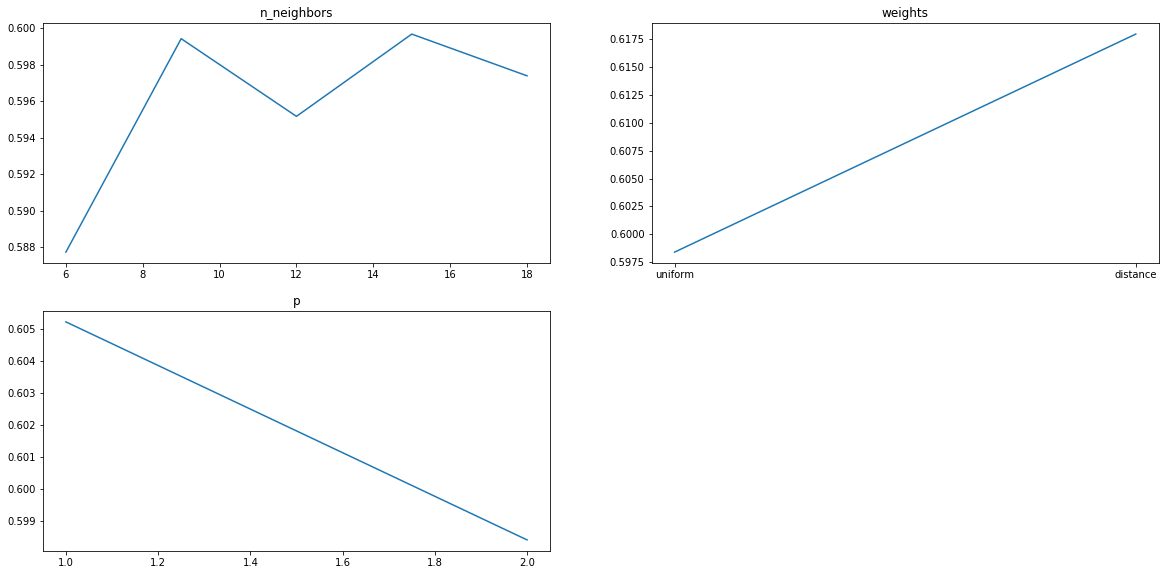

In [12]:
parameters = {
  'n_neighbors': np.arange(6, 21, 3),
  'weights': [
    'uniform',
    'distance'
  ],
  'p': [1, 2]
}

ranking = evaluate_parameters(
    parameters, 
    classifier=KNeighborsClassifier(n_jobs=-1),
    X_train=X_train,
    y_train=y_train.ravel()
)

In [13]:
parameters = {
  'n_neighbors': np.arange(6, 12, 3),
  'weights': ['distance'],
  'p': [1]
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_grid=parameters,
    verbose=10,
    n_jobs=-1,
    cv=3,
    scoring='recall'
)
grid_search.fit(X_train, y_train.ravel())
best_estimator = grid_search.best_estimator_

print_metrics(
    classifier=best_estimator,
    X_test=X_test,
    y_test=y_test
)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   21.6s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   21.6s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   22.2s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.2s finished


Accuracy: 0.6436763538317625, Precision: 0.6795016821166757, Recall: 0.6629733681162744, F score: 0.6711357782856314


## Naive Bayes

We will be training a Gaussian NB classifier because most of the features we have are numerical.

In [14]:
X = final_df[[
  'DayOfWeek',
  'x_cartesian',
  'y_cartesian',
  'sin_time',
  'cos_time',
]]

X = pd.get_dummies(X)

X = X.values
y = final_df[['is_violent']].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

Below is a trained NB classifier

In [15]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train.ravel())

print_metrics(
    classifier=nb_classifier,
    X_test=X_test,
    y_test=y_test
)

Accuracy: 0.5622224143758893, Precision: 0.5828121326122737, Recall: 0.7104429699479786, F score: 0.640329632715272


## Linear SVM

Lastly, we'll look look into a linear SVM. We will use all the features and scale them using min-max scaling due to the nature of SVMs.

Unfortunately, we weren't able to use a kernel SVM due to the size of our dataset. We attempted to train an SVM with an RBF kernel, however it took too long for us to tune it in a timely fashion.

In [16]:
X = final_df[[
  'year',
  'DayOfWeek',
  'x_cartesian',
  'y_cartesian',
  'sin_time',
  'cos_time',
]]

X = pd.get_dummies(X)
X = X.values
y = final_df[['is_violent']].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We'll train a baseline linear SVM for comparison.

In [17]:
# Baseline

linear_SVM = LinearSVC(C=0.025, dual=False, random_state=0)
linear_SVM.fit(X_train, y_train)

print_metrics(
    classifier=linear_SVM,
    X_test=X_test,
    y_test=y_test
)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5674262850494839, Precision: 0.5785604834820998, Recall: 0.7747374160592321, F score: 0.6624298377449928


Next, we'll evaluate a set of parameters with different values: `C` and `tol`

C
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.7s remaining:    1.3s
/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished


penalty
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    1.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    8.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.2s finished


tol
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    4.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    5.1s finished


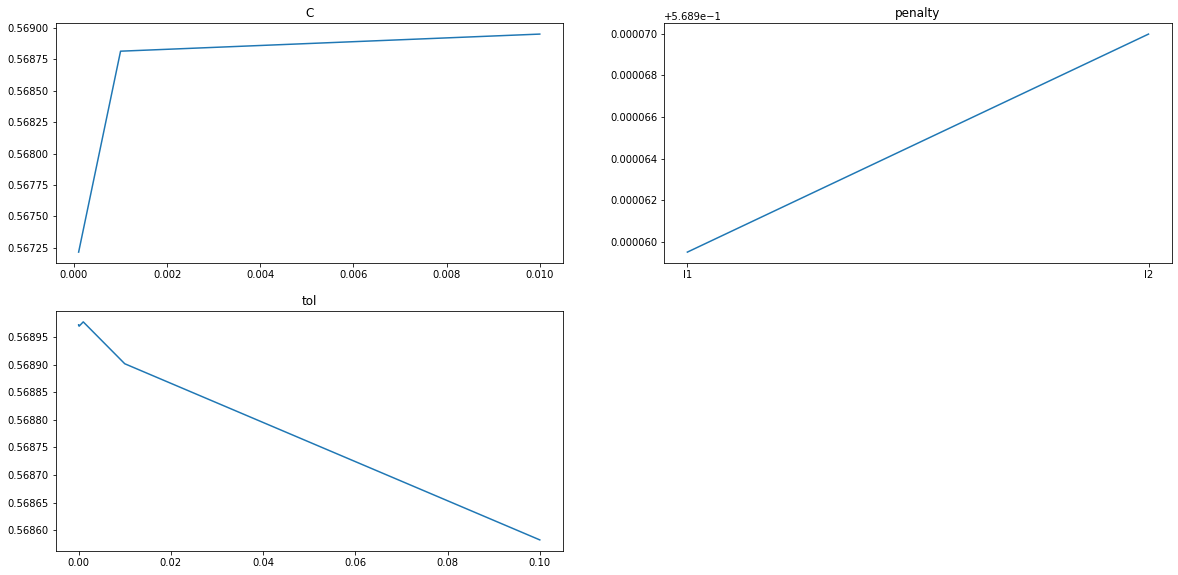

In [18]:
parameters = {
  'C': [
    1e-4,
    1e-3,
    1e-2
  ],
  'penalty': [
    'l1',
    'l2'
  ],
  'tol': [
    1e-8,
    1e-7,
    1e-6,
    1e-5,
    1e-4,
    1e-3,
    1e-2,
    1e-1
  ]
}

ranking = evaluate_parameters(
    parameters, 
    classifier=LinearSVC(dual=False),
    X_train=X_train,
    y_train=y_train.ravel()
)

Using the plots above we can fine-tune the parameter values, then perform the grid search

In [19]:
parameters = {
  'C': [
    1e-4,
    1e-3,
    1e-2
  ],
  'penalty': [
    'l1',
    'l2'
  ],
  'tol': [
    1e-8,
    1e-7,
    1e-6,
    1e-5,
    1e-4,
    1e-3,
    1e-2,
  ]
}

grid_search = GridSearchCV(
    estimator=LinearSVC(dual=False),
    param_grid=parameters,
    verbose=10,
    n_jobs=-1,
    cv=3,
    scoring='recall'
)
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_

print_metrics(
    classifier=best_estimator,
    X_test=X_test,
    y_test=y_test
)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.4min finished
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Accuracy: 0.5532217619268471, Precision: 0.5548651416865824, Recall: 0.9327899902427825, F score: 0.6958234324492112


As can be seen above, the Recall for this model is 92%. However, a problem with this model is the very low precision. It is just above 50%, which shows that its precision is similar to that of a random/dumb classifier.